In [1]:
from fasttext_utils import get_processed_data
docs = get_processed_data(split=False)["text"].to_list()

/tmp/ipykernel_17352/3066291985.py:2: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  docs = get_processed_data(split=False)["text"].to_list()


In [2]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import pandas as pd

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
docs = [doc if not pd.isnull(doc) else "" for doc in tqdm(docs) ]
for idx in tqdm(range(len(docs))):
    # print(docs[idx])
    if not pd.isnull(docs[idx]): 
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in tqdm(docs)]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in tqdm(docs)]


100%|██████████| 217801/217801 [00:08<00:00, 26673.77it/s]


In [3]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in tqdm(docs)]

100%|██████████| 217801/217801 [03:59<00:00, 908.93it/s]


In [2]:
lda_text_path = "../tmp/lda_text"
lda_dict_path = "../tmp/lda_dict"

In [3]:
# Compute bigrams.
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.test.utils import datapath
from tqdm import tqdm 

docs = [line.split() for line in tqdm(open(lda_text_path, encoding='utf-8'))]
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in tqdm(range(len(docs))):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

217801it [00:09, 23761.07it/s]
100%|██████████| 217801/217801 [02:48<00:00, 1295.68it/s]


In [4]:
file = open(lda_text_path, "w")

for doc in tqdm(docs):
    file.write(" ".join(doc) + "\n")

file.close()

100%|██████████| 217801/217801 [00:03<00:00, 67945.50it/s]


In [3]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary
from tqdm import tqdm

# # Create a dictionary representation of the documents.
# dictionary = Dictionary(line.split() for line in tqdm(open(lda_text_path, encoding='utf-8')))

# # Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)

# dictionary.save(lda_dict_path)
dictionary = Dictionary.load(lda_dict_path)

In [4]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(line.split()) for line in tqdm(open(lda_text_path, encoding='utf-8'))]

217801it [00:39, 5477.97it/s]


In [5]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 58250
Number of documents: 217801


In [23]:
# Set training parameters.
num_topics = 20
chunksize = 300000
passes = 2
iterations = 10
eval_every = None  # Don't evaluate model perplexity, takes too much time.

In [24]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Train LDA model.
from gensim.models import LdaModel



# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
)

model.save('../tmp/lda_model.model')

2021-11-24 12:21:30,218 : INFO : using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2021-11-24 12:21:30,223 : INFO : using serial LDA version on this node
2021-11-24 12:21:30,296 : INFO : running online (multi-pass) LDA training, 20 topics, 2 passes over the supplied corpus of 217801 documents, updating model once every 217801 documents, evaluating perplexity every 0 documents, iterating 10x with a convergence threshold of 0.001000
2021-11-24 12:21:30,297 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-11-24 12:21:30,320 : INFO : PROGRESS: pass 0, at document #217801/217801
2021-11-24 12:22:46,154 : INFO : optimized alpha [0.094072685, 0.09409368, 0.09404111, 0.094196126, 0.0936708, 0.09407636, 0.0943042, 0.09440609, 0.09432423, 0.09395358, 0.094281375, 0.094028585, 0.09391856, 0.09399173, 0.

In [ ]:
from gensim.models import LdaModel

model = LdaModel.load("../tmp/lda_model.model")

In [25]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2021-11-24 12:23:55,621 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-11-24 12:23:55,664 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2021-11-24 12:23:55,702 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2021-11-24 12:23:55,740 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2021-11-24 12:23:55,778 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2021-11-24 12:23:55,816 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2021-11-24 12:23:55,856 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2021-11-24 12:23:55,894 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2021-11-24 12:23:55,931 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2021-11-24 12:23:55,971 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2021-11-24 12:23:56,008 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2021-11-24 12:23:56

Average topic coherence: -0.8631.
[([(0.0043572565, 'user'),
   (0.004299265, 'network'),
   (0.0035560073, 'new'),
   (0.0034253437, 'service'),
   (0.0031903822, 'performance'),
   (0.0029904186, 'technique'),
   (0.0029878593, 'information'),
   (0.0028951862, 'each'),
   (0.0028423998, 'approach'),
   (0.0028133714, 'may'),
   (0.0027637868, 'two'),
   (0.002576748, 'other'),
   (0.002576711, 'algorithm'),
   (0.0025137623, 'problem'),
   (0.002511403, 'study'),
   (0.002468453, 'their'),
   (0.0024545288, 'level'),
   (0.002327944, 'more'),
   (0.0023155059, 'between'),
   (0.0023125622, 'different')],
  -0.7306727707662001),
 ([(0.0077070193, 'network'),
   (0.004563072, 'information'),
   (0.0040372675, 'approach'),
   (0.0038758381, 'service'),
   (0.0038510973, 'set'),
   (0.003845481, 'performance'),
   (0.0033266025, 'algorithm'),
   (0.002880801, 'two'),
   (0.0028567074, 'been'),
   (0.002841626, 'different'),
   (0.0027984953, 'problem'),
   (0.002792357, 'user'),
   (0.0

In [26]:
from fasttext_utils import get_processed_data
import pandas as pd

train_vecs = []
for i in tqdm(range(len(corpus))):
    top_topics = model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    train_vecs.append(topic_vec)

vect = pd.DataFrame(train_vecs, columns=["lda_cat_{}".format(i+1) for i in range(num_topics)])

100%|██████████| 217801/217801 [01:16<00:00, 2829.04it/s]


In [18]:
vect.head()

,lda_cat_1,lda_cat_2,lda_cat_3,lda_cat_4,lda_cat_5,lda_cat_6,lda_cat_7,lda_cat_8,lda_cat_9,lda_cat_10
0,0.000119,0.015576,0.077639,0.411411,0.000052,0.047198,0.000101,0.000077,0.023571,0.424257
1,0.425105,0.000086,0.233312,0.000117,0.000085,0.000122,0.000164,0.000125,0.298927,0.041957
2,0.561852,0.000106,0.000187,0.000145,0.000106,0.000151,0.138242,0.000154,0.000123,0.298934
3,0.341588,0.000194,0.087606,0.000266,0.000194,0.040502,0.412175,0.000283,0.000226,0.116967
4,0.948000,0.000197,0.000346,0.000270,0.000196,0.000280,0.000376,0.000286,0.049628,0.000420


In [28]:
data = get_processed_data(split=False)
vect["author"] = data["author"]

/tmp/ipykernel_19185/1043321290.py:1: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  data = get_processed_data(split=False)


<AxesSubplot:>

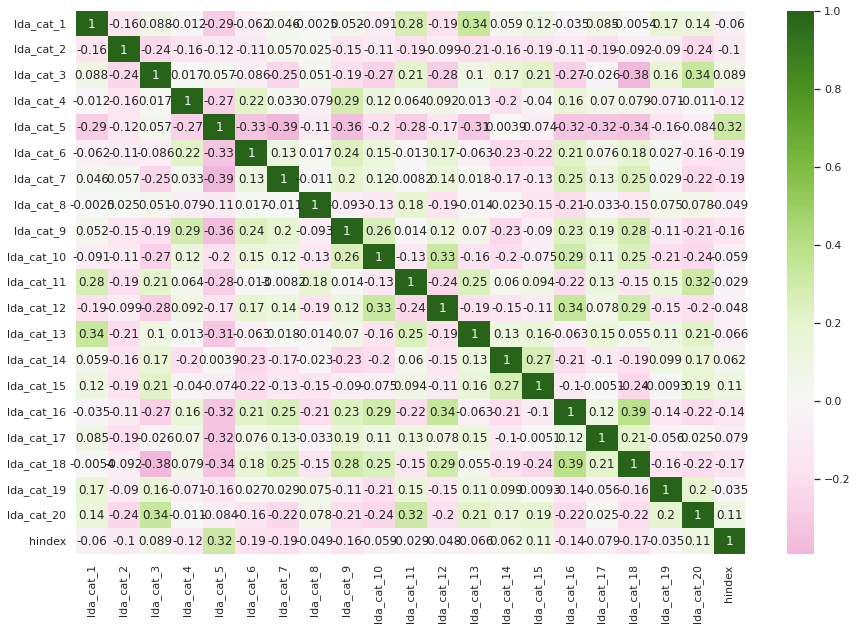

In [29]:
import seaborn as sns

# calculate the correlation matrix
vect_copy = vect.copy()
vect_copy = vect_copy.drop("author", axis=1)
vect_copy["hindex"] = data["hindex"]
corr = vect_copy.corr()

# plot the heatmap
sns.set(rc={"figure.figsize":(15, 10)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="PiYG",
        annot = True, center = 0)

In [21]:
data = data.merge(vect, left_on="author", right_on="author", how="inner")

In [29]:
from fasttext_utils import select_columns
data = select_columns(data)
data.head()

,author,hindex,nb_paper,pagerank,authority,clustering_coef,n_neighbors_dist_1,mean_neighbors_dist_1,max_neighbors_dist_1,vector_coord_0,...,lda_cat_1,lda_cat_2,lda_cat_3,lda_cat_4,lda_cat_5,lda_cat_6,lda_cat_7,lda_cat_8,lda_cat_9,lda_cat_10
0,1964267543,4.0,5,0.000004,3.339138e-13,1.000000,5,21.800000,39,-0.186604,...,0.000119,0.015576,0.077639,0.411411,0.000052,0.047198,0.000101,0.000077,0.023571,0.424257
1,2153592714,13.0,5,0.000002,1.433035e-17,1.000000,2,20.000000,20,-0.239073,...,0.425105,0.000086,0.233312,0.000117,0.000085,0.000122,0.000164,0.000125,0.298927,0.041957
2,217158525,8.0,5,0.000003,6.750288e-20,1.000000,2,2.000000,2,-0.225883,...,0.561852,0.000106,0.000187,0.000145,0.000106,0.000151,0.138242,0.000154,0.000123,0.298934
3,2123103677,11.0,3,0.000005,7.714573e-16,0.714286,7,11.833333,54,-0.174987,...,0.341588,0.000194,0.087606,0.000266,0.000194,0.040502,0.412175,0.000283,0.000226,0.116967
4,2067710487,3.0,2,0.000004,-1.444459e-26,0.000000,2,9.841160,12,-0.170414,...,0.948000,0.000197,0.000346,0.000270,0.000196,0.000280,0.000376,0.000286,0.049628,0.000420


In [45]:
from fasttext_utils import TRAIN_LENGTH
from sklearn.model_selection import train_test_split
vect["hindex"] = data["hindex"]
# ["lda_cat_5", "lda_cat_6", "lda_cat_7", "lda_cat_9", "author", "hindex"]
train = vect[:TRAIN_LENGTH]
vect.drop("hindex", axis=1)
train = train.sample(n=TRAIN_LENGTH, random_state=1)
train, test = train_test_split(train, random_state=1)
X_train = train.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_train = train["hindex"].to_numpy()
X_test = test.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_test = test["hindex"].to_numpy()

In [43]:
X_train.shape

(130680, 4)

In [44]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
model_cat = CatBoostRegressor(verbose=False, num_trees=2000)
model_cat.fit(X_train, y_train)
mod_preds = model_cat.predict(X_test)
mean_squared_error(y_test,mod_preds)

129.5909126824394